In [1]:
import random
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.core.display as di

#from keras.utils import np_utils

In [2]:
random.seed(9001)
pd.options.mode.chained_assignment = None
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


### item dataset

In [3]:
def preprossing(df):
    # missing value
    df = df.drop(["campaignIndex"], axis=1)
    df.pharmForm = df.pharmForm.fillna(value=df[~(df['pharmForm'].isnull())].pharmForm.mode()[0])
    df.category = df.category.fillna(value=df[~(df['category'].isnull())].category.mode()[0])
    # 將大小寫統一
    df.pharmForm = df.pharmForm.str.upper()
    # 處理content的資料型態
    content = pd.DataFrame(df.content.str.split('X',2).tolist(), columns = ['x','y','z'])
    content = content.fillna('1')
    content.x = pd.to_numeric(content.x, errors='coerce')
    content.y = pd.to_numeric(content.y, errors='coerce')
    content.z = pd.to_numeric(content.z, errors='coerce')
    content = content.fillna('1')
    content.x = pd.to_numeric(content.x, errors='coerce')
    content.y = pd.to_numeric(content.y, errors='coerce')
    content.z = pd.to_numeric(content.z, errors='coerce')
    df['content'] = content.x * content.y * content.z

    # 將categorical columns轉成數字型態
    df.group = df.group.astype("category").cat.codes
    df.unit = df.unit.astype("category").cat.codes
    df.pharmForm = df.pharmForm.astype("category").cat.codes
    #df = pd.get_dummies(df)
    return df

In [4]:
df_items = pd.read_csv("items.csv", sep = "|")
print ("shape of items dataset :", df_items.shape)
print (df_items.isnull().sum())
df_items = preprossing(df_items)
df_items.to_csv("items_clean.csv", index=False)
df_items.head()

shape of items dataset : (22035, 11)
pid                   0
manufacturer          0
group                 0
content               0
unit                  0
pharmForm          2327
genericProduct        0
salesIndex            0
category           4627
campaignIndex     20697
rrp                   0
dtype: int64


,pid,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,rrp
0,1,1,529,80.0,7,135,0,40,3.0,10.89
1,2,1,529,80.0,7,135,0,40,3.0,10.89
2,3,1,529,10.0,1,45,0,40,3.0,16.45
3,4,1,529,80.0,7,135,0,40,3.0,10.89
4,5,2,74,8.0,7,112,0,40,1.0,22.53


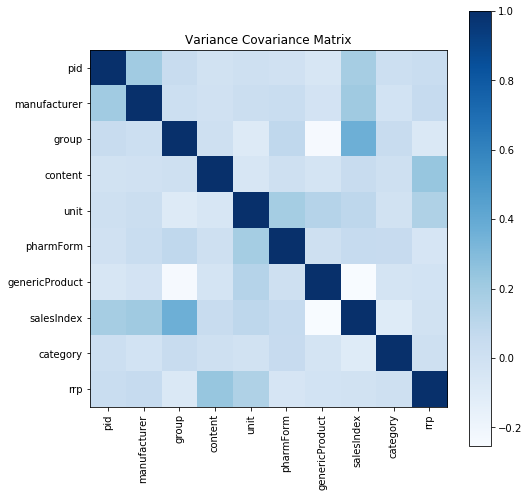

In [5]:
# variance and covariance matrix
df_items.corr()

plt.figure(num=None, figsize=(8, 8))
plt.imshow(df_items.corr(), cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(df_items.columns))]
plt.xticks(tick_marks, df_items.columns, rotation='vertical')
plt.yticks(tick_marks, df_items.columns)
plt.title('Variance Covariance Matrix', fontsize = 12)

plt.show()

### train&class dataset

In [6]:
def importdataset(path):
    df = pd.read_csv(path, sep = "|")
    print ("shape of dataset :", df.shape)
    print (df.isnull().sum())
    df.competitorPrice = df.competitorPrice.fillna(value = df.price)
    return df

In [7]:
path_train = "train.csv"
df_train = importdataset(path_train)

# 競爭對手價格高購買數量會多；競爭對手價格低購買數量會少 (diff>0 -> 比較貴；diff<0 -> 比較便宜)
df_train["diff_price"] = df_train.price - df_train.competitorPrice
df_train["number"] = df_train.revenue/df_train.price

# labeling
df_c = df_train[df_train.click == 1]
df_b = df_train[df_train.basket == 1]
df_o = df_train[df_train.order == 1]
df_c["label"] = 0
df_b["label"] = 1
df_o["label"] = 2
df_train = pd.concat([df_c, df_b, df_o], axis=0).sort_values(['lineID'], ascending = True).reset_index(drop = True)
df_train = df_train.drop(["click","basket","order"], axis=1)
df_train.to_csv("train_clean.csv", index=False)

path_test = "class.csv"
df_class = importdataset(path_test)
df_class.to_csv("class_clean.csv", index=False)


shape of dataset : (2756003, 11)
lineID                  0
day                     0
pid                     0
adFlag                  0
availability            0
competitorPrice    100687
click                   0
basket                  0
order                   0
price                   0
revenue                 0
dtype: int64
shape of dataset : (1210767, 7)
lineID                 0
day                    0
pid                    0
adFlag                 0
availability           0
competitorPrice    38005
price                  0
dtype: int64


### 利用之前購買的資訊(total)增加變數

In [8]:
f = {'day':['max','min','mean'],
     'adFlag':['count','mean'],
     'availability':['mean'],
     'competitorPrice':['max','min','mean'],
     'price':['max','min','mean'],
     'diff_price':['max','min','mean'],
     'revenue':['mean'],
     'number':['max','min','mean','sum'],
     'label':['sum']}
col = ["pid",
       "day_max","day_min","day_mean",
       "pid_count","ad_mean",
       "avail_mean",
       "competitor_max","competitor_min","competitor_mean",
       "price_max","price_min","price_mean",
       "diff_max","diff_min","diff_mean",
       "rev_mean",
       "number_max","number_min","number_mean","pid_sum",
       "pid_prefer"]

g = df_train.groupby(["pid"]).aggregate(f).reset_index()
g.columns = [col]
g.to_csv("pid_info.csv", index=False)
g.head()

,pid,day_max,day_min,day_mean,pid_count,ad_mean,avail_mean,competitor_max,competitor_min,competitor_mean,...,price_mean,diff_max,diff_min,diff_mean,rev_mean,number_max,number_min,number_mean,pid_sum,pid_prefer
0,1,59,10,36.500000,8,0.0,3.000000,8.79,8.22,8.410000,...,9.102500,1.86,-0.94,0.692500,0.910000,1.0,0.0,0.125000,1.0,3
1,2,41,12,31.000000,3,0.0,3.000000,10.08,8.42,9.526667,...,9.526667,0.00,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0
2,3,89,1,63.714286,14,0.0,3.000000,15.62,12.23,13.749286,...,13.749286,0.00,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0
3,4,89,2,49.230769,13,0.0,1.769231,8.71,8.22,8.556923,...,9.945385,1.86,-0.41,1.388462,4.555385,2.0,0.0,0.461538,6.0,12
4,5,92,8,51.275862,29,0.0,2.000000,18.06,17.59,17.848966,...,19.124138,3.82,-3.32,1.275172,0.000000,0.0,0.0,0.000000,0.0,1


### Visualization

Shape of order = 1     : 468086
Shape of order = 0     : 2287917
Shape of total dataset : 2756003


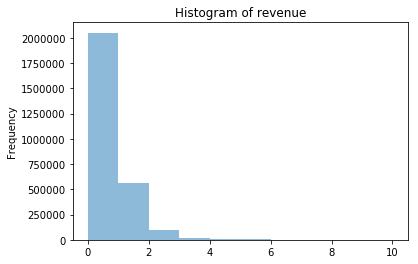

In [9]:
# 了解購買數量的分布
con = (df_train.number <= 10)
df_train[con].number.plot(kind="hist", title="Histogram of revenue", bins=10, alpha=0.5)

print("Shape of order = 1     :", df_train[df_train.label == 1].shape[0])
print("Shape of order = 0     :", df_train[df_train.label != 1].shape[0])
print("Shape of total dataset :", df_train.shape[0])
#plt.savefig('./output/3.png', dpi=300)
plt.show()

In [10]:
# availability v.s 購買狀況
table = pd.crosstab(index = df_train["availability"], columns = df_train["label"], margins = False)  
table.columns = ["click","basket","order"]#, "tol_availability"]  
table.index = ["availability1","availability2", "availability3", "availability4"]#, "tol_order"]  

print (table)

                 click  basket   order
availability1  1398619  443497  673456
availability2   138987   19227   26980
availability3    34894    5348    4651
availability4    10327      14       3


In [11]:
# adflag v.s 購買狀況
table = pd.crosstab(index = df_train["adFlag"], columns = df_train["label"], margins = False)  
table.columns = ["click","basket","order"]#, "tol_availability"]  
table.index = ["non-ad","ad"]#, "tol_order"]  

print (table)

          click  basket   order
non-ad  1193629  263820  422727
ad       389198  204266  282363


In [12]:
# merge train&item and split training&testing
df = pd.merge(df_train, df_items, how='inner', on=['pid']).sort_values(['lineID'], ascending = True).reset_index(drop = True)

train = df[(df.day <= 62)].sort_values(['lineID'], ascending = True).reset_index(drop = True)
test = df[(df.day > 62)].sort_values(['lineID'], ascending = True).reset_index(drop = True)

print('Number of train : %d' % train.shape[0])
print('Number of test  : %d' % test.shape[0])
df.head()

Number of train : 1782748
Number of test  : 973255


,lineID,day,pid,adFlag,availability,competitorPrice,price,revenue,diff_price,number,label,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,rrp
0,1,1,6570,0,2,14.60,16.89,0.00,2.29,0.0,0,255,529,50.0,5,147,0,40,193.0,18.25
1,2,1,14922,1,1,8.57,8.75,0.00,0.18,0.0,1,18,373,50.0,7,135,1,40,66.0,18.81
2,3,1,16382,0,1,14.77,16.06,0.00,1.29,0.0,1,41,503,100.0,5,130,0,53,40.0,18.48
3,4,1,1145,1,1,6.59,6.55,6.55,-0.04,1.0,2,52,308,60.0,1,44,0,40,25.0,9.31
4,5,1,3394,0,1,4.39,4.14,4.14,-0.25,1.0,2,90,458,50.0,7,75,0,53,14.0,8.13


### 利用之前購買的資訊(train)增加變數

In [13]:
g = train.groupby(["pid"]).aggregate(f).reset_index()
g.columns = [col]
g.to_csv("pid_info_train.csv", index=False)
g.head()

,pid,day_max,day_min,day_mean,pid_count,ad_mean,avail_mean,competitor_max,competitor_min,competitor_mean,...,price_mean,diff_max,diff_min,diff_mean,rev_mean,number_max,number_min,number_mean,pid_sum,pid_prefer
0,1,59,10,36.500000,8,0.0,3.000000,8.79,8.22,8.410000,...,9.102500,1.86,-0.94,0.692500,0.91,1.0,0.0,0.125000,1.0,3
1,2,41,12,31.000000,3,0.0,3.000000,10.08,8.42,9.526667,...,9.526667,0.00,0.00,0.000000,0.00,0.0,0.0,0.000000,0.0,0
2,3,41,1,13.000000,4,0.0,3.000000,15.21,15.21,15.210000,...,15.210000,0.00,0.00,0.000000,0.00,0.0,0.0,0.000000,0.0,0
3,4,60,2,32.666667,9,0.0,1.666667,8.71,8.22,8.488889,...,9.996667,1.86,1.09,1.507778,3.36,1.0,0.0,0.333333,3.0,7
4,5,59,8,38.263158,19,0.0,2.000000,18.06,17.59,17.894737,...,18.224211,3.24,-3.32,0.329474,0.00,0.0,0.0,0.000000,0.0,0


> 利用train做出來的變數去做validation才有意義